## Enabling Active-Provenance in dispel4py - How To:



### Sample Workflow Description and Components (Compoenents are implemented as Classe or as Functions)
<br/>

<li>1 - Produces a stream of numbers - Source (Class)</li>
<li>2 - Calculates the square-product for each number - square (fuction)</li>
<li>3 - Streams out the cartesian product of (numbers X square-products) - CrossProd (Class)</li>
<li>4 - Divides (square-product/number) for each incoming element of the cartesian product - Div (Class)</li>

The script below defines the components and declares the workflow. Its execution will show a visual representation of the abstract workfkow grap.

While most of the processing elements are stateless, the <i>CrossProd</i> Class shows how to use the <i>write</i> method and the <i>addToState</i> to precisely trace stateful dependencies, in the case of the generation of a cross-product output.

### Function addToProvState 
Adds an object and its metadata to the PEs state. This can be referenced from the user during write operations, increasing the lineage precision in stateful components.

The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>data</i>: object to be stored in the provenance state</li>

#### Named Parameters:
<li> 2 - <i>location</i>: url or path indicating the location of the data file, if any has been produced</li>
<li> 3 - <i>metadata</i>: dictionary of key,values pairs od user-defined metadata associated to the object.</li>
<li> 4 - <i>ignore_dep</i>: If <b>True</b> the dependencies which are currently standing are ignored, default True</li>
<li> 5 - <i>stateless</i>:  If <b>True</b> the item added is not included as new standing dependencies, default True</li>



<br/>


SETTING NAME: Source
SETTING NAME: Div
SETTING NAME: CrossProd
SETTING NAME: SimpleFunctionPE
SETTING NAME: SimpleFunctionPE


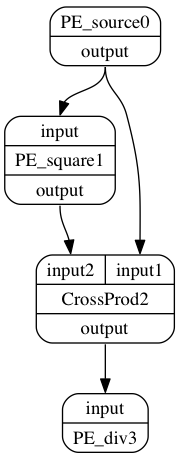

In [1]:
from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
import time
import random
import traceback 
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return
from dispel4py.visualisation import display
from IPython.display import HTML


class Source(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
        print inputs
    
        if 'input' in inputs:
            #self.log('from input')
            inp=inputs['input'][0]
       
        #Strarting from the number received in input, streams out values until >0
        while (inp>0):
            self.write('output',inp,metadata={'iter':inp})
            inp=inp-5
        
        
        


def square(data,prov_cluster):
    data=data*data
    
    #User-defined metadata and format associated to the function output.
    prov={'format':'Random float', 'metadata':{'value_s':str(data)}}
    
    return {'_d4p_prov':prov,'_d4p_data':data} 
    
    
    
class Div(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
            
    def _process(self,data):
        self.log("DIIIIV: "+str(data)) 
        val = data['input'][0]/data['input'][1]
        self.write('output',val,metadata={'val':val})
             
            
            
            
            
class CrossProd(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input1')
        self._add_input('input2')
        self._add_output('output')
        self.index1=0
        self.index2=0
        self.indexmap1={}
        self.indexmap2={}
         
         
        
    def _process(self, inputs):
        index=None
        val=None
        
         
            
        try:
            val = inputs['input1']
            self.indexmap1[self.index1]=val
            
            #Adds the object and the associated metadata to the PEs state for later reference
            self.addToProvState(str('index1'+str(self.index1)),self.indexmap1[self.index1],metadata={'res':str(self.indexmap1[self.index1])},ignore_inputs=False)
            self.index1+=1
            
            for x in self.indexmap2:
                
                # Writes the output and specify additional dependencies. 
                # Specifically, it refer to the object read from the list used to produce 
                # the cross product
                self.write('output', (val, self.indexmap2[x]), metadata={'res':str((val, self.indexmap2[x]))},dep=[str('index2'+str(x))])
            
        except KeyError:
            traceback.print_exc(file=sys.stderr)
            val = inputs['input2']
            self.indexmap2[self.index2]=val
            
            #Adds the object and the associated metadata to the PEs state for later reference
            self.addToProvState('index2'+str(self.index2),self.indexmap2[self.index2],metadata={'res':str(self.indexmap2[self.index2])},ignore_inputs=False)
            self.index2+=1
            
            for x in self.indexmap1:
                
                # Writes the output and specify additional dependencies. 
                # Specifically, it refer to the object read from the list used to produce 
                # the cross product
                self.write('output', (val, self.indexmap1[x]), metadata={'res':str((val, self.indexmap1[x]))},dep=[str('index1'+str(x))])
        
       
# Instantiates the Workflow Components        

sc = Source()
sc.name='PE_source'
divf=Div()
divf.name='PE_div'
crossp = CrossProd()
squaref=SimpleFunctionPE(square,{})
#Uncomment this line to associate this PE to the mycluster provenance-cluster 
squaref=SimpleFunctionPE(square,{'prov_cluster':'mycluster'})


#Initialise and compose the workflow graph
graph = WorkflowGraph()
graph.connect(sc,'output',squaref,'input')
graph.connect(sc,'output',crossp,'input1')
graph.connect(squaref,'output',crossp,'input2')
graph.connect(crossp,'output',divf,'input')


#Declare workflow inputs:
input_data = {"PE_source": [{"input": [10]}]}


#Visualise the graph
display(graph)





## Preparing the workflow graph for provenance production, pre-analysis and storage

This snippet will make sure that the workflow compoentns will be provenance-aware and the lineage information sent to the designated ProvenanceRecorders for in-workflow pre-analysis.

The execution will show a new graph where it will be possible to validate the provenance-cluster, if any, and the correct association of ProvenanceRecorders and feedback connections.

The graph will change according to the declaration of self.prov_cluster property of the processing elements and to the specification of different ProvenanceRecorders and feedback loops, as described below:

### Function InitiateNewRun 
Prepares the workflow with the required provenance mechanisms
The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>worfklow graph</i></li>
<li> 2 - Class name implementing the default <i>ProvenanceRecorder</i></li>

#### Named Parameters
<li> 3 - <i>provImpClass</i>: Class name extending the default <i>ProvenancePE</i>. The current type of the workflow components (GenericPE) will be extended with the one indicated by the <i>provImpClass</i> type</li>
<li> 4 - <i>username</i></li>
<li> 5 - <i>runId</i></li>
<li> 6 - <i>w3c_prov</i>: specifies if the PE will outupt lineage in PROV format (default=False)</li>
<li> 7 - <i>workflowName</i></li>
<li> 8 - <i>workflowId</i></li>
<li> 9 - <i>clustersRecorders</i>: dictionary associating <i>provenance-clusters</i> with a specific <i>ProvenanceRecorder</i> (overrides the default <i>ProvenanceRecorder</i>) </li>
<li> 10 - <i>feedbackPEs</i>: list of PE names receiving and processing feedbacks from the <i>ProvenanceRecorder</i>. </li>

<br/>




SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'aspinuso', 'workflowId': 'xx', 'description': '', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_orfeus-as-68306-557eec7a-6a9d-11e6-bdcd-f45c89acf865', 'startTime': '2016-08-25 08:24:25.825315', 'input': [], '_id': 'RDWD_orfeus-as-68306-557eec7a-6a9d-11e6-bdcd-f45c89acf865', 'type': 'workflow_run', 'workflowName': 'test_rdwd'}
SimplePE: Processed 1 iteration.
Outputs: {}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CrossProd Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: CrossProd Transoformed: <class 'dispel4py.provenance.<class '__main__.CrossProd'>'>
Change grouping implementation 
Injecting provenance to: PE_div Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: PE_div Transoformed: <class 'dispel

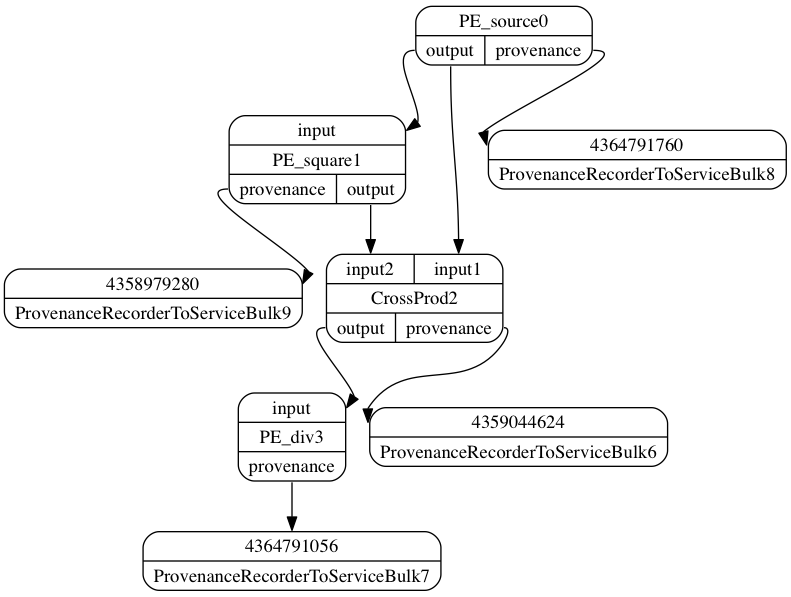

In [2]:
#Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes
ProvenanceRecorder.REPOS_URL='http://localhost/prov/workflow/insert'

# Ranomdly generated unique identifier for the current run
rid='RDWD_'+getUniqueId()

# if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
os.environ['PROV_PATH']="./prov-files/"

# Finally, provenance enhanced graph is prepared:
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

#.. and visualised..
display(graph)

### Execution
The followin instruction executes the workfklow in single-process mode
<br/>

In [3]:
#Launch in simple process
process_and_return(graph, input_data)

SETTING NAME: SimpleProcessingPE
{'input': [10]}
PE_div3: DIIIIV: {'input': (100, 10)}
PE_div3: DIIIIV: {'input': (100, 5)}
PE_div3: DIIIIV: {'input': (25, 10)}
PE_div3: DIIIIV: {'input': (25, 5)}
SimplePE: Processed 1 iteration.


Traceback (most recent call last):
  File "<ipython-input-1-04b8ad8d4c65>", line 89, in _process
    val = inputs['input1']
KeyError: 'input1'
Traceback (most recent call last):
  File "<ipython-input-1-04b8ad8d4c65>", line 89, in _process
    val = inputs['input1']
KeyError: 'input1'


{'PE_div3': {'output': [{'TriggeredByProcessIterationID': 'PE_div-orfeus-as-68306-586b8d97-6a9d-11e6-83c9-f45c89acf865',
    '_d4p': 10,
    'id': 'orfeus-as-68306-586b8fba-6a9d-11e6-b0aa-f45c89acf865'},
   {'TriggeredByProcessIterationID': 'PE_div-orfeus-as-68306-586b9700-6a9d-11e6-a8f1-f45c89acf865',
    '_d4p': 20,
    'id': 'orfeus-as-68306-586b98c2-6a9d-11e6-ba41-f45c89acf865'},
   {'TriggeredByProcessIterationID': 'PE_div-orfeus-as-68306-586b9fa1-6a9d-11e6-8296-f45c89acf865',
    '_d4p': 2,
    'id': 'orfeus-as-68306-586ba151-6a9d-11e6-9585-f45c89acf865'},
   {'TriggeredByProcessIterationID': 'PE_div-orfeus-as-68306-586ba970-6a9d-11e6-92aa-f45c89acf865',
    '_d4p': 5,
    'id': 'orfeus-as-68306-586bab3a-6a9d-11e6-b587-f45c89acf865'}]}}

## Developing ProvenanceRecorders

The Class below show a sample <i>ProvenanceRecorderToService</i> and a slightlty more advanced one that allows for feedback.

### ProvenanceRecorderToService

Recieves traces from the PEs and sends them out to an exteranal provenance store.



In [ ]:

class ProvenanceRecorderToService(ProvenanceRecorder):

    def __init__(self, name='ProvenanceRecorderToService', toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.name = name
        self.convertToW3C = toW3C
        # self.inputconnections[ProvenanceRecorder.INPUT_NAME] = {
        # "name": ProvenanceRecorder.INPUT_NAME}

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)
        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def _process(self, inputs):
        
        #ports are assigned automatically as numbers, we just need to read from any of these
        for x in inputs:
            prov = inputs[x]
            
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

        params = urllib.urlencode({'prov': json.dumps(out)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST",
            self.provurl.path,
            params,
            headers)

        response = self.connection.getresponse()
        print("Response From Provenance Serivce: ", response.status,
              response.reason, response, response.read())
        self.connection.close()
        return None

    def postprocess(self):
        self.connection.close()



### MyProvenanceRecorderWithFeedback

Recieves traces from the PEs and reads its content. Depending from the 'name' of the PE sending the lineage, feedbacks are prepared and sent back.

In [ ]:

class MyProvenanceRecorderWithFeedback(ProvenanceRecorder):

    def __init__(self, toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.convertToW3C = toW3C
        self.bulk = []
        self.timestamp = datetime.datetime.utcnow()

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)

        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def postprocess(self):
        self.connection.close()
        
    def _process(self, inputs):
        prov = None
        for x in inputs:
            prov = inputs[x]
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

            
            
        self.write(self.porttopemap[prov['name']], "FEEDBACK MESSAGGE FROM RECORDER")

        self.bulk.append(out)
        params = urllib.urlencode({'prov': json.dumps(self.bulk)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST", self.provurl.path, params, headers)
        response = self.connection.getresponse()
        self.log("progress: " + str((response.status, response.reason,
                                         response, response.read())))
        

        return None

## Preparing the workflow graph for active provenance with feedback
Here we show how to implement a PE that can handle feedback from a <i>ProvenanceRecoder</i>. We redefine the worklow graph with the same structure as the provious one but with the new PE

### Class DivFeedback
It requires the implementation of the <i>_process_feedbak</i> function. The function will be invoked automatically by the framework when a feedback is sent.
<br/>

In [ ]:
class DivFeedback(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
         
         
        
    def _process_feedback(data):
        print "FEEEEDBACK: "+str(data)
    
    def _process(self,data):
        self.log("DIIIIV: "+str(data)) 
        val = data['input'][0]/data['input'][1]
        self.write('output',val,metadata={'val':val})
# Instantiates the Workflow Components        

sc = Source()
sc.name='PE_source'
divf=DivFeedback()
divf.name='PE_DivFeedback'
divf.prov_cluster='mycluster'
crossp = CrossProd()
#squaref=SimpleFunctionPE(square,{})
#Uncomment this line to associate this PE to the mycluster provenance-cluster 
squaref=SimpleFunctionPE(square,{'prov_cluster':'mycluster'})


#Initialise and compose the workflow graph
graph = WorkflowGraph()
graph.connect(sc,'output',squaref,'input')
graph.connect(sc,'output',crossp,'input1')
graph.connect(squaref,'output',crossp,'input2')
graph.connect(crossp,'output',divf,'input')


HTML('Simple Graph <br/>')
display(graph)

#Declare workflow inputs:
input_data = {"PE_source": [{"input": [10]}]}

# Preparing the workflow graph for provenance production, pre-analysis and storage
# Ranomdly generated unique identifier for the current run
rid='RDWD_'+getUniqueId()

# if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
os.environ['PROV_PATH']="./prov-files/"

# Finally, provenance enhanced graph is prepared:
InitiateNewRun(graph,ProvenanceRecorderToService,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx",clustersRecorders={'mycluster':MyProvenanceRecorderWithFeedback},feedbackPEs=['PE_DivFeedback'])

#.. and visualised..

display(graph)

### Execution with Feedback
As a temporary requirement, feedback workflows have to bee executed in multiprocessing mode
<br/>


In [ ]:
#Launch in simple process
process_and_return(graph, input_data)